# see what angles get reconstructed well

In [1]:
import jkutils
import os, sys
import numpy as np
import scipy.stats as stats
from keras.models import load_model
import math
import shelve
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
% matplotlib inline

Using Theano backend.
/home/jkager/.local/lib/python2.7/site-packages/pandas/core/computation/__init__.py:18: UserWarning: The installed version of numexpr 2.4.3 is not supported in pandas and will be not be used
The minimum supported version is 2.4.6

  ver=ver, min_ver=_MIN_NUMEXPR_VERSION), UserWarning)


# analyze test_results

In [2]:
#charge
today = '2017-08-24'
project_name = 'charge_h012_v1'

In [3]:
#time
today = '2017-08-24'
project_name = 'time_h012_v1'

In [4]:
file_location = '/data/user/jkager/NN_Reco/johannes/updownclassification_3/'
data_location = '/data/user/jkager/NN_Reco/training_data_20x10x60/'
test_results = 'test_results.npy'

project_folder = 'train_hist/{}/{}'.format(today, project_name)
print "looking for", project_folder
if not os.path.exists(os.path.join(file_location,project_folder)):
    print "project not found. exiting..."
    sys.exit(-1)
elif not os.path.exists(os.path.join(file_location, project_folder, test_results)):
    print "test results not found. exiting..."
    sys.exit(-1)
print "found"
shelf = shelve.open(os.path.join(file_location, project_folder, 'run_info.shlf'))
input_files = shelf['Files'].split(':')
if len(input_files) == 1: #this could be something like ['h01'] (inputformat)
    #try to decode fileinput format
    input_files = jkutils.get_filenames(input_files[0])
    for f in input_files:
        if not os.path.isfile(os.path.join(data_location, 'training_data/{}'.format(f))):
            print "file not found:", f
            print "exiting script."
            sys.exit(1)
train_inds = shelf['Train_Inds'] 
valid_inds = shelf['Valid_Inds']
test_inds = shelf['Test_Inds']
test_results = np.load(os.path.join(file_location, project_folder, test_results))
input_data, out_data, file_len = jkutils.read_files(input_files, data_location, using=shelf['using'])

looking for train_hist/2017-08-24/time_h012_v1
found


res is the output value of the network. test_out is the expected value (0 or 1, up or down depending on the real zenith value). zenith_out is the real zenith value

In [5]:
res, test_out, zenith_out = test_results[0,:], test_results[1,:], test_results[2,:] #network output (0 or 1), 
                                                                                    #desired output (0 or 1),
                                                                                    #zenith (0 to pi)

In [6]:
bins = 10*18+1
x_hist = np.linspace(0,math.pi,bins)
y_hist = np.zeros((bins-1))
cor, summe = 0, 0
for i in range(len(x_hist)-1):
    indizes = np.bitwise_and(zenith_out >= x_hist[i], zenith_out < x_hist[i+1])
    correct = np.sum(np.round(res[indizes]) == jkutils.zenith_to_binary(zenith_out[indizes]))
    print correct, np.sum(indizes), x_hist[i] * 180/math.pi
    cor += correct
    summe += np.sum(indizes)
    y_hist[i] = float(correct)/np.sum(indizes)
print cor / float(summe)

12 14 0.0
40 41 1.0
47 56 2.0
92 103 3.0
120 133 4.0
140 150 5.0
177 188 6.0
208 225 7.0
208 227 8.0
223 235 9.0
253 280 10.0
244 260 11.0
276 294 12.0
255 287 13.0
280 301 14.0
310 331 15.0
302 336 16.0
321 357 17.0
364 407 18.0
319 356 19.0
364 393 20.0
391 421 21.0
385 434 22.0
373 402 23.0
410 466 24.0
367 422 25.0
386 434 26.0
412 453 27.0
391 430 28.0
437 489 29.0
408 475 30.0
414 468 31.0
437 493 32.0
432 483 33.0
443 496 34.0
446 495 35.0
459 518 36.0
499 545 37.0
474 531 38.0
518 581 39.0
465 513 40.0
502 538 41.0
500 539 42.0
554 589 43.0
496 547 44.0
538 589 45.0
583 641 46.0
551 593 47.0
555 602 48.0
556 606 49.0
577 611 50.0
626 652 51.0
595 621 52.0
656 698 53.0
602 644 54.0
678 702 55.0
696 722 56.0
716 745 57.0
675 703 58.0
784 824 59.0
743 771 60.0
755 785 61.0
765 798 62.0
816 840 63.0
771 791 64.0
848 871 65.0
826 848 66.0
903 921 67.0
838 854 68.0
893 911 69.0
962 977 70.0
963 979 71.0
981 1001 72.0
991 1014 73.0
1050 1072 74.0
971 994 75.0
989 1005 76.0
1053 1076 7

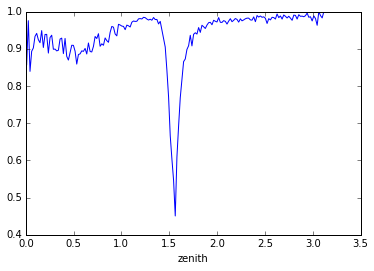

In [7]:
plt.figure()
plt.plot(x_hist[:-1]+math.pi/(bins-1)/2,y_hist)
plt.xlabel('zenith')
plt.show()

In [8]:
true_pos, true_neg = 0, 0
false_pos, false_neg = 0, 0
reals, preds = [], []
for pred, real in zip(res, test_out):
    if real == 1:
        if pred < 0.5:
            false_neg += 1
        else:
            true_pos += 1
    if real == 0:
        if pred > 0.5:
            false_pos += 1
        else:
            true_neg += 1
    reals.append(real)
    preds.append(pred)

In [9]:
print "         |    pos    |    neg    "
print "---------+-----------+-----------"
sum_all = true_pos + false_pos + true_neg + false_neg
if sum_all == 0:
    print "no data"
print "test pos |{:10.2f}%|{:10.2f}%".format(100 * true_pos / float(sum_all), 100 * false_pos / float(sum_all))
print "test neg |{:10.2f}%|{:10.2f}%".format(100 * false_neg / float(sum_all), 100 * true_neg / float(sum_all))


print "---------+-----------+-----------\n"*2,    
print "         |    pos    |    neg    "
print "---------+-----------+-----------" 
print "test pos |{:11.0f}|{:11.0f}".format(100 * true_pos, 100 * false_pos)
print "test neg |{:11.0f}|{:11.0f}".format(100 * false_neg, 100 * true_neg)

         |    pos    |    neg    
---------+-----------+-----------
test pos |     51.25%|      4.44%
test neg |      2.82%|     41.49%
---------+-----------+-----------
---------+-----------+-----------
         |    pos    |    neg    
---------+-----------+-----------
test pos |    6423500|     556100
test neg |     353700|    5200300


In [10]:
print "\n".join(map(str, zip(reals, preds))[:200])

(1.0, 0.9986264705657959)
(1.0, 0.16152086853981018)
(0.0, 0.00034043632331304252)
(1.0, 0.99805128574371338)
(1.0, 0.99730503559112549)
(1.0, 0.99995172023773193)
(1.0, 0.99906235933303833)
(1.0, 0.99985742568969727)
(0.0, 1.0549966646067332e-05)
(1.0, 0.97882163524627686)
(1.0, 0.18986433744430542)
(1.0, 0.95469653606414795)
(0.0, 0.0014480318641290069)
(1.0, 0.31810095906257629)
(1.0, 0.99770206212997437)
(0.0, 0.19017940759658813)
(1.0, 0.99577635526657104)
(0.0, 0.003799935569986701)
(1.0, 0.99764388799667358)
(1.0, 0.98945504426956177)
(1.0, 0.99902582168579102)
(1.0, 0.9982638955116272)
(1.0, 0.99820089340209961)
(0.0, 0.0076321708038449287)
(1.0, 0.9993627667427063)
(1.0, 0.97248071432113647)
(1.0, 0.99826329946517944)
(0.0, 0.0073660095222294331)
(1.0, 0.89859479665756226)
(0.0, 0.01819021999835968)
(1.0, 0.99906164407730103)
(1.0, 0.98411464691162109)
(0.0, 0.31598615646362305)
(1.0, 0.75635993480682373)
(0.0, 0.005715253297239542)
(0.0, 0.15248973667621613)
(1.0, 0.999982476

## accuracy over number of hit bins

In [8]:
def num_hit_bins(input_set):
    ret = 0
    for j in input_set.flatten():
        if shelf['using'] == 'time' and j != np.inf:
            ret += 1
        if shelf['using'] == 'charge' and j > 0.0:
            ret += 1
    return ret

In [9]:
def get_pos_in_res(i_file, i_in_testsets):
    before = sum([test_inds[i][1] - test_inds[i][0] for i in range(i_file)])
    return before + i_in_testsets

In [56]:
#works very slowly... tried it with evaluation.py on condor. 
bins = 100
input_shape = input_data[0].shape[1:-1]
x_bins = np.linspace(0,reduce(lambda x, y: x*y, input_shape),bins)
y_acc_data = [[] for i in range(bins-1)]
cor, summe = 0, 0
for file_n in range(len(input_data)):
    print "file", file_n
    for i, inp_s in enumerate(input_data[file_n][test_inds[file_n][0]:test_inds[file_n][1]]):
        n_hit = num_hit_bins(inp_s)
        if n_hit == x_bins[-1]:
            bin_n = bins - 2
        else:
            bin_n = np.digitize(np.array([n_hit]), x_bins)[0] - 1
        #remember if it was correctly reconstructed
        index = get_pos_in_res(file_n, i)
        print index
        correct = np.round(res[index]) == jkutils.zenith_to_binary(zenith_out[index]) #latter is same as test_out
        y_acc_data[bin_n].append(correct)
y_acc = [float(sum(i))/len(i) if len(i) > 0 else None for i in y_acc_data]

0
1
2
3


KeyboardInterrupt: 

In [17]:
#use already calculated results
nhits = np.array(np.load("save_ndoms_h012_testsets.npy"),dtype=np.int)

In [52]:
bins = 100
input_shape = input_data[0].shape[1:-1]
#x_bins = np.linspace(0,reduce(lambda x, y: x*y, input_shape),bins)
x_bins = np.linspace(0,300,bins)
y_acc_data = [[] for i in range(bins-1)]
cor, summe = 0, 0
for i, n_hit in enumerate(nhits):
    if n_hit > x_bins[-1]:
        continue
    if n_hit == x_bins[-1]:
        bin_n = bins - 2
    else:
        bin_n = np.digitize(np.array([n_hit]), x_bins)[0] - 1
    #remember if it was correctly reconstructed
    index = i
    correct = np.round(res[index]) == jkutils.zenith_to_binary(zenith_out[index]) #latter is same as test_out
    y_acc_data[bin_n].append(correct)
y_acc = [float(sum(i))/len(i) if len(i) > 0 else None for i in y_acc_data]

In [53]:
print '\n'.join(["{:9.2f}  {:.3f} {:5d}".format(c,a,b) for c,a,b in zip(x_bins[:-1], y_acc_zero, [len(i) for i in y_acc_data])])

     0.00  0.000     0
     3.03  0.983     0
     6.06  0.966     0
     9.09  0.938     0
    12.12  0.916     0
    15.15  0.889     0
    18.18  0.870     1
    21.21  0.862     5
    24.24  0.882    20
    27.27  0.883    90
    30.30  0.878   212
    33.33  0.878   507
    36.36  0.896   900
    39.39  0.897  1347
    42.42  0.914  1692
    45.45  0.906  2160
    48.48  0.915  2311
    51.52  0.925  2502
    54.55  0.936  2528
    57.58  0.946  2547
    60.61  0.949  2467
    63.64  0.943  2228
    66.67  0.950  2248
    69.70  0.946  2027
    72.73  0.944  1867
    75.76  0.954  1731
    78.79  0.966  1621
    81.82  0.964  1563
    84.85  0.960  1442
    87.88  0.963  1395
    90.91  0.972  1334
    93.94  0.960  1287
    96.97  0.970  1198
   100.00  0.973  1505
   103.03  0.977  1118
   106.06  0.975  1128
   109.09  0.968  1025
   112.12  0.975   979
   115.15  0.975   949
   118.18  0.980   912
   121.21  0.967   871
   124.24  0.972   813
   127.27  0.978   819
   130.30  

In [54]:
y_acc_zero = np.array([i if i is not None else 0.0 for i in y_acc])

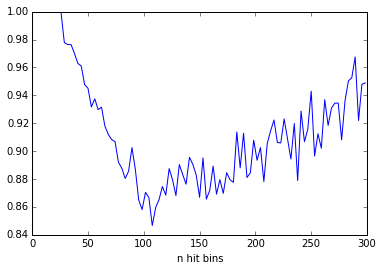

In [55]:
plt.figure()
plotbins=x_bins[:-1]+float(x_bins[-1]-x_bins[0])/(len(x_bins)-1)/2
plt.plot(np.array(plotbins)[y_acc_zero>0], y_acc_zero[y_acc_zero>0])
plt.xlabel('n hit bins')
plt.show()

In [72]:
filt=nhits<35

In [73]:
np.sum(filt)

469

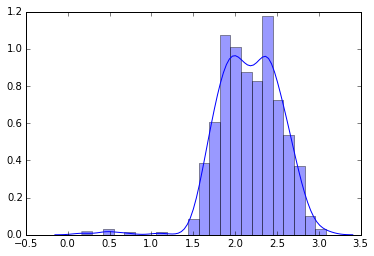

In [74]:
sns.distplot(zenith_out[filt])

In [26]:
input_data[0][0].flatten()[0] == np.inf

True

In [35]:
x_bins

array([     0.        ,    121.21212121,    242.42424242,    363.63636364,
          484.84848485,    606.06060606,    727.27272727,    848.48484848,
          969.6969697 ,   1090.90909091,   1212.12121212,   1333.33333333,
         1454.54545455,   1575.75757576,   1696.96969697,   1818.18181818,
         1939.39393939,   2060.60606061,   2181.81818182,   2303.03030303,
         2424.24242424,   2545.45454545,   2666.66666667,   2787.87878788,
         2909.09090909,   3030.3030303 ,   3151.51515152,   3272.72727273,
         3393.93939394,   3515.15151515,   3636.36363636,   3757.57575758,
         3878.78787879,   4000.        ,   4121.21212121,   4242.42424242,
         4363.63636364,   4484.84848485,   4606.06060606,   4727.27272727,
         4848.48484848,   4969.6969697 ,   5090.90909091,   5212.12121212,
         5333.33333333,   5454.54545455,   5575.75757576,   5696.96969697,
         5818.18181818,   5939.39393939,   6060.60606061,   6181.81818182,
         6303.03030303,  